In [1]:
from dask.distributed import Client, LocalCluster
import dask.array as da
from dask.array.image import imread  # For reading images directly into Dask arrays
import matplotlib.pyplot as plt
from skimage.filters import gaussian, sobel
import imageio.v3 as imageio

In [9]:
 #cluster = LocalCluster(n_workers=2, threads_per_worker=2, memory_limit='4GB')
 #client = Client(cluster)
client = Client("tcp://172.31.31.30:8786")
print("Dashboard URL:", client.dashboard_link)

Dashboard URL: http://172.31.31.30:8787/status


In [6]:
 # Load an image directly into a Dask array
image_path = "https://delvex-software-center.s3.ap-south-1.amazonaws.com/USGS/ashu.jpg"  # Replace with the path to your image
dask_image1 = imageio.imread(image_path)  # Load image directly as a Dask array
# convert to dask array 
dask_image = da.from_array(dask_image1)
 # Print the shape and chunks of the Dask array
print("Dask Image Shape:", dask_image.shape)
print("Dask Image Chunks:", dask_image.chunks)

Dask Image Shape: (3000, 4000, 3)
Dask Image Chunks: ((3000,), (4000,), (3,))


/home/ubuntu/ashu-env/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004618387182107193..1.0000000000000002].


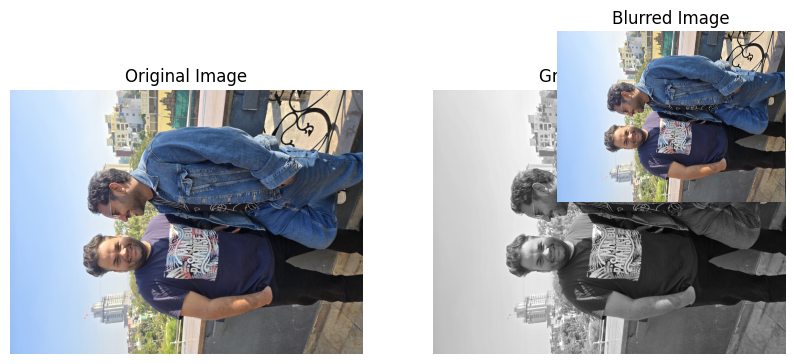

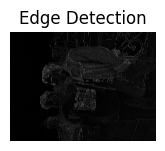

NameError: name 'cluster' is not defined

In [10]:
# Remove the extra dimension (if present)
if dask_image.ndim == 4 and dask_image.shape[0] == 1:
    dask_image = dask_image.squeeze(axis=0)  # Remove the first dimension

# Perform a transformation (e.g., convert to grayscale)
def to_grayscale(rgb):
    return rgb[..., 0] * 0.2989 + rgb[..., 1] * 0.5870 + rgb[..., 2] * 0.1140

grayscale_image = dask_image.map_blocks(to_grayscale, dtype=dask_image.dtype)

# 2. Apply Gaussian blur
def apply_gaussian_blur(image):
    return gaussian(image, sigma=2, channel_axis=-1)  # Apply Gaussian blur

blurred_image = dask_image.map_blocks(apply_gaussian_blur, dtype=dask_image.dtype)

# 3. Edge detection using Sobel filter
def apply_edge_detection(image):
    return sobel(to_grayscale(image))  # Apply Sobel filter on grayscale image

edge_image = dask_image.map_blocks(apply_edge_detection, dtype=dask_image.dtype)

# Compute the result
grayscale_image_computed = grayscale_image.compute()
blurred_image_computed = blurred_image.compute()
edge_image_computed = edge_image.compute()

# Display the original and transformed images using matplotlib
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(dask_image.compute())  # Compute and display the original image
plt.title("Original Image")
plt.axis("off")

# Grayscale image
plt.subplot(1, 2, 2)
plt.imshow(grayscale_image_computed, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")

# Blurred image
plt.subplot(2, 3, 3)
plt.imshow(blurred_image_computed)
plt.title("Blurred Image")
plt.axis("off")
plt.show()

# Edge image 
plt.subplot(2, 3, 4)
plt.imshow(edge_image_computed,cmap="gray")
plt.title("Edge Detection")
plt.axis("off")

plt.show()
# Shut down the cluster
client.close()
